### Imbalanced Learning

In [1]:
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = datasets.make_classification(n_samples=5000, n_features=2, n_informative=2,
                                            n_redundant=0, n_repeated=0, n_classes=2,
                                            n_clusters_per_class=1,
                                            weights=[0.95, 0.05],
                                            class_sep=0.5, random_state=0)

dataset_df = pd.DataFrame({'X1':X[:,0],'X2':X[:,1], 'Y':y})

In [3]:
dataset_df.head()

,X1,X2,Y
0,-0.167337,0.081432,0
1,-0.023532,-0.527046,0
2,-0.577801,0.458236,0
3,0.343891,0.803027,0
4,-0.488292,0.675787,0


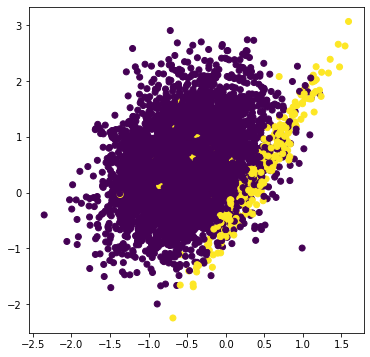

In [4]:
plt.figure(figsize = (6, 6))

plt.scatter(x = dataset_df['X1'],y = dataset_df['X2'], c = dataset_df['Y'] )

## Cost_sensitive_learning

### Decision tree

Let us now train a decision tree to separate the two classes. We use a decision tree of depth 5, and a stratified 5-fold cross-validation to assess the performances of the classifier. The performances are assessed in terms of AUC ROC, Average precision, and balanced accuracy. The class weights are set to 1 for both classes.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate


In [6]:
classifier = DecisionTreeClassifier(max_depth=5,class_weight={0:1,1:1},random_state=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [7]:
cv_results_ = cross_validate(classifier, X, y, cv=cv,
                                                scoring=['roc_auc',
                                                        'average_precision',
                                                        'balanced_accuracy'],
                                                return_estimator=True)

In [8]:
results = round(pd.DataFrame(cv_results_),3)
results

,fit_time,score_time,estimator,test_roc_auc,test_average_precision,test_balanced_accuracy
0,0.006,0.003,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.933,0.616,0.842
1,0.006,0.003,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.871,0.493,0.739
2,0.007,0.003,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.897,0.493,0.799
3,0.007,0.003,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.928,0.591,0.812
4,0.007,0.004,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.901,0.447,0.738


Let us take the mean and standard deviation of the performances across all folds.

In [9]:
results_mean = list(results.mean().values)
results_std = list(results.std().values)

pd.DataFrame([[str(round(results_mean[i],3))+'+/-'+str(round(results_std[i],3)) for i in range(len(results))]],
            columns=['Fit time (s)','Score time (s)','AUC ROC','Average Precision','Balanced accuracy'])

/tmp/ipykernel_55755/3263762727.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/tmp/ipykernel_55755/3263762727.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
0,0.007+/-0.001,0.003+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046


Les performances sont plutôt bonnes puisque l'AUC ROC est largement supérieur à 0,5 et la précision moyenne supérieure à 0,05. La précision équilibrée n'est cependant pas aussi élevée, ce qui suggère que la frontière de décision classe mal de nombreux échantillons de la classe minoritaire.

Traçons enfin la frontière de décision fournie par l'un des arbres de décision. Nous utilisons l'arbre de décision obtenu à partir du premier pli de la validation croisée.	

In [10]:
# Retrieve the decision tree from the first fold of the cross-validation
classifier_0 = cv_results_['estimator'][0]

In [11]:
# Retrieve the indices used for the training and testing of the first fold of the cross-validation
(train_index, test_index) = next(cv.split(X, y))

# Recreate the train and test DafaFrames from these indices
train_df = pd.DataFrame({'X1':X[train_index,0], 'X2':X[train_index,1], 'Y':y[train_index]})
test_df = pd.DataFrame({'X1':X[test_index,0], 'X2':X[test_index,1], 'Y':y[test_index]})
input_features = ['X1','X2']
output_feature = 'Y'

In [12]:
def plot_decision_boundary_classifier(ax, 
                                      classifier,
                                      train_df,
                                      input_features=['X1','X2'],
                                      output_feature='Y',
                                      title="",
                                      fs=14,
                                      plot_training_data=True):

    plot_colors = ["tab:blue","tab:orange"]

    x1_min, x1_max = train_df[input_features[0]].min() - 1, train_df[input_features[0]].max() + 1
    x2_min, x2_max = train_df[input_features[1]].min() - 1, train_df[input_features[1]].max() + 1
    
    plot_step=0.1
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
                         np.arange(x2_min, x2_max, plot_step))

    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu_r,alpha=0.3)

    if plot_training_data:
        # Plot the training points
        groups = train_df.groupby(output_feature)
        for name, group in groups:
            ax.scatter(group[input_features[0]], group[input_features[1]], edgecolors='black', label=name)
        
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel(input_features[0], fontsize=fs)
    ax.set_ylabel(input_features[1], fontsize=fs)

In [13]:
%%capture
fig_decision_boundary, ax = plt.subplots(1, 3, figsize=(5*3,5))

plot_decision_boundary_classifier(ax[0], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n With training data",
                                  plot_training_data=True)

plot_decision_boundary_classifier(ax[1], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n",
                                  plot_training_data=False)


plot_decision_boundary_classifier(ax[2], classifier_0,
                                  test_df,
                                  title="Decision surface of the decision tree\n With test data",
                                  plot_training_data=True)

ax[-1].legend(loc='upper left', 
              bbox_to_anchor=(1.05, 1),
              title="Class")

sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=0, vmax=1))
cax = fig_decision_boundary.add_axes([0.93, 0.15, 0.02, 0.5])
fig_decision_boundary.colorbar(sm, cax=cax, alpha=0.3, boundaries=np.linspace(0, 1, 11))

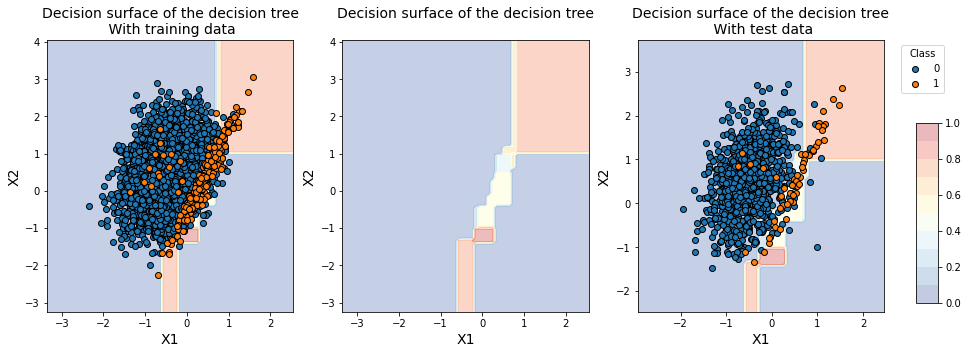

In [14]:
fig_decision_boundary


For better visualization, we report the decision boundaries alone (middle), with the training data (left), and with the test data (right). The plots show that the decision tree correctly identifies the region where the minority class samples lie. The decision tree however mostly classifies samples from the overlapping region into the majority class (yellow/blue color gradient).

We will reuse the functions above for computing the performances and for plotting the decision boundaries. For the sake of code conciseness, we implement two functions for computing the cross-validation results (kfold_cv_with_classifier) and for plotting the decision boundaries (plot_decision_boundary).

In [15]:
def kfold_cv_with_classifier(classifier,
                             X,
                             y,
                             n_splits=5,
                             strategy_name="Basline classifier"):
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    
    cv_results_ = cross_validate(classifier,X,y,cv=cv,
                                                         scoring=['roc_auc',
                                                                  'average_precision',
                                                                  'balanced_accuracy'],
                                                         return_estimator=True)
    
    results = round(pd.DataFrame(cv_results_),3)
    results_mean = list(results.mean().values)
    results_std = list(results.std().values)
    results_df = pd.DataFrame([[str(round(results_mean[i],3))+'+/-'+
                                str(round(results_std[i],3)) for i in range(len(results))]],
                              columns=['Fit time (s)','Score time (s)',
                                       'AUC ROC','Average Precision','Balanced accuracy'])
    results_df.rename(index={0:strategy_name}, inplace=True)
    
    classifier_0 = cv_results_['estimator'][0]
    
    (train_index, test_index) = next(cv.split(X, y))
    train_df = pd.DataFrame({'X1':X[train_index,0], 'X2':X[train_index,1], 'Y':y[train_index]})
    test_df = pd.DataFrame({'X1':X[test_index,0], 'X2':X[test_index,1], 'Y':y[test_index]})
    
    return (results_df, classifier_0, train_df, test_df)

In [16]:
def plot_decision_boundary(classifier_0,
                           train_df, 
                           test_df):
    
    fig_decision_boundary, ax = plt.subplots(1, 3, figsize=(5*3,5))

    plot_decision_boundary_classifier(ax[0], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n With training data",
                                  plot_training_data=True)

    plot_decision_boundary_classifier(ax[1], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n",
                                  plot_training_data=False)


    plot_decision_boundary_classifier(ax[2], classifier_0,
                                  test_df,
                                  title="Decision surface of the decision tree\n With test data",
                                  plot_training_data=True)

    ax[-1].legend(loc='upper left', 
                  bbox_to_anchor=(1.05, 1),
                  title="Class")

    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=0, vmax=1))
    cax = fig_decision_boundary.add_axes([0.93, 0.15, 0.02, 0.5])
    fig_decision_boundary.colorbar(sm, cax=cax, alpha=0.3, boundaries=np.linspace(0, 1, 11))
    
    return fig_decision_boundary

In [17]:
%%capture
classifier = DecisionTreeClassifier(max_depth=5,class_weight={0:1,1:1},random_state=0)


(results_df_dt_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                     X, y, 
                                                                                     n_splits=5,
                                                                                     strategy_name="Decision tree - Baseline")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [18]:
results_df_dt_baseline

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.01+/-0.001,0.005+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046


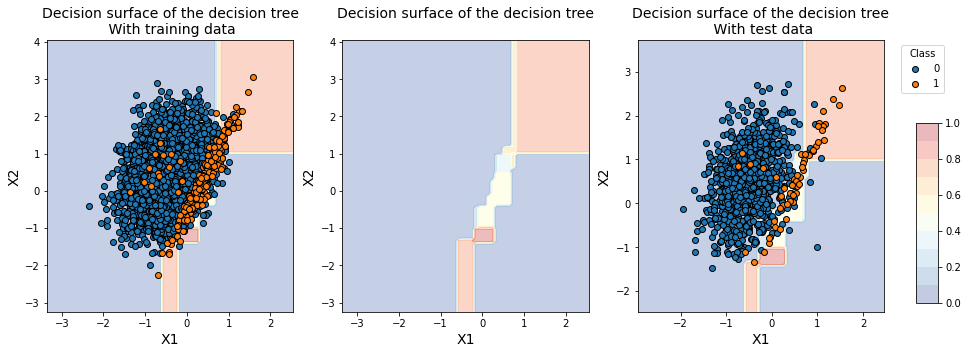

In [19]:
fig_decision_boundary

## IR

Let us now set the class weights so that false positives have a weight equal to the imbalance ratio.

        - IR=0.05/0.95


In [20]:
IR=0.05/0.95
class_weight={0:IR,1:1}


In [21]:
%%capture
classifier = DecisionTreeClassifier(max_depth=5,class_weight=class_weight,random_state=0)

(results_df_dt_cost_sensitive, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                         X, y, 
                                                                         n_splits=5,
                                                                         strategy_name="Decision tree - Cost-sensitive")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [22]:
pd.concat([results_df_dt_baseline, 
           results_df_dt_cost_sensitive])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.01+/-0.001,0.005+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - Cost-sensitive,0.008+/-0.002,0.003+/-0.001,0.887+/-0.034,0.471+/-0.059,0.898+/-0.021


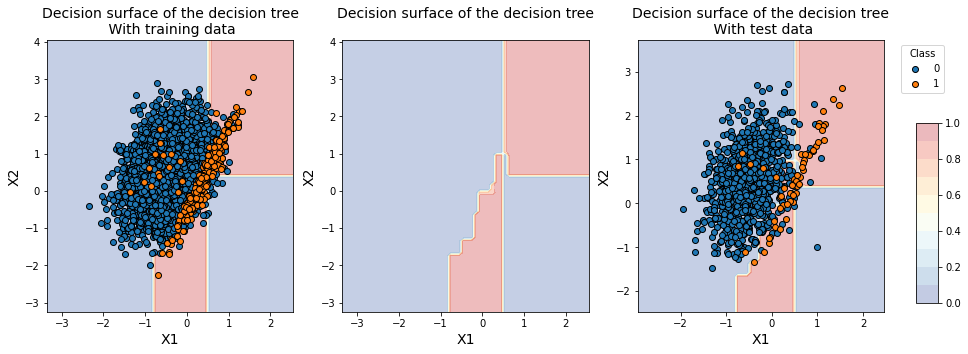

In [23]:
fig_decision_boundary


Nous observons que la limite de décision a été déplacée vers les échantillons de la classe minoritaire. Ce déplacement a permis d'augmenter les performances en termes de précision équilibrée, qui est passée de 0,786+/-0,046 à 0,898+/-0,021. Nous notons cependant que les performances en termes d'AUC ROC et de précision moyenne ont toutes deux diminué.

### Logistic regression

Let us now apply the same methodology with a logistic regression classifier. We first build a classifier with equal weights for the two classes and run a stratified 5-fold cross-validation.

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
%%capture
classifier = LogisticRegression(C=1,class_weight={0:1,1:1},random_state=0)

(results_df_lr_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                          X, y, 
                                                                          n_splits=5,
                                                                          strategy_name="Logistic regression - Baseline")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [26]:
results_df_lr_baseline

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.008+/-0.001,0.003+/-0.001,0.937+/-0.012,0.535+/-0.065,0.641+/-0.048


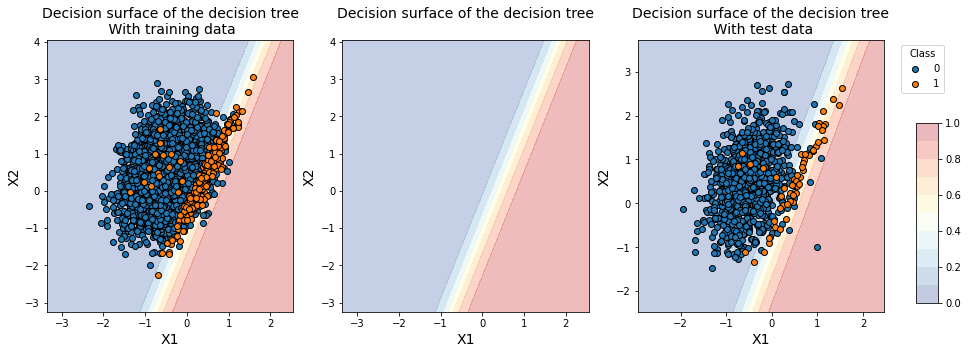

In [27]:
fig_decision_boundary


The decision boundary illustrates the linear separation that results from logistic regression. Due to the class imbalance, we observe that the decision boundary slightly favors the majority class.

As for the decision tree, let us change the class weights, using the imbalance ratio as the weight for the majority class.

In [28]:
%%capture
classifier = LogisticRegression(C=1,class_weight={0:IR,1:1},random_state=0)

(results_df_lr_cost_sensitive, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                         X, y, 
                                                                         n_splits=5,
                                                                         strategy_name="Logistic regression - Cost-sensitive")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [29]:
pd.concat([results_df_lr_baseline, results_df_lr_cost_sensitive])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.008+/-0.001,0.003+/-0.001,0.937+/-0.012,0.535+/-0.065,0.641+/-0.048
Logistic regression - Cost-sensitive,0.01+/-0.002,0.004+/-0.001,0.937+/-0.012,0.536+/-0.064,0.899+/-0.01


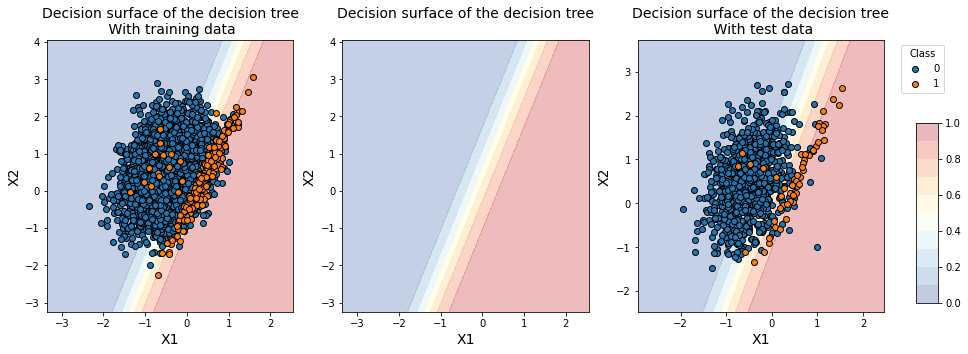

In [30]:
fig_decision_boundary

We observe that the decision boundary moved to the left, favoring the classification of the minority class. We note a strong increase of the balanced accuracy, from 0.641+/-0.048 to 0.899+/-0.01. The AUC ROC and Average Precision remain as good as the classifier with equal weights.

The examples above show that tuning the class weights can improve classification performances. It is however worth noting that the performance improvements depend on the performance metric. For both classifiers, reducing the class weight of the majority class allowed to increase the balanced accuracy. The accuracy in terms of AUC ROC and Average Precision however remained unchanged for logistic regression and decreased for decision trees.

In [31]:
results_df = pd.concat([results_df_dt_baseline,
                        results_df_dt_cost_sensitive,
                        results_df_lr_baseline,
                        results_df_lr_cost_sensitive])
results_df

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.01+/-0.001,0.005+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - Cost-sensitive,0.008+/-0.002,0.003+/-0.001,0.887+/-0.034,0.471+/-0.059,0.898+/-0.021
Logistic regression - Baseline,0.008+/-0.001,0.003+/-0.001,0.937+/-0.012,0.535+/-0.065,0.641+/-0.048
Logistic regression - Cost-sensitive,0.01+/-0.002,0.004+/-0.001,0.937+/-0.012,0.536+/-0.064,0.899+/-0.01


## Resampling strategies

### Oversampling

Oversampling techniques aim at rebalancing the dataset by creating new samples for the minority class.

#### Random oversampling

The imblearn library provides objects called samplers, which take as input a dataset and a set of parameters that are specific to the sampler, and return a resampled dataset.

For example, the imblearn sampler for random oversampling is called **RandomOverSampler**. Its main parameter is the sampling_strategy, which determines the desired imbalance ratio after random oversampling.

In [32]:
from imblearn.over_sampling import RandomOverSampler



In [33]:
# random_state is set to 0 for reproducibility
ROS = RandomOverSampler(sampling_strategy=1, random_state=0)

In [34]:
dataset_df.head()

,X1,X2,Y
0,-0.167337,0.081432,0
1,-0.023532,-0.527046,0
2,-0.577801,0.458236,0
3,0.343891,0.803027,0
4,-0.488292,0.675787,0


In [35]:
dataset_df['Y'].value_counts()


0    4730
1     270
Name: Y, dtype: int64

In [36]:
X_resampled, Y_resampled = ROS.fit_resamplesample(dataset_df[['X1','X2']], dataset_df['Y'])
df_ROS = pd.DataFrame({'X1':X_resampled['X1'],'X2':X_resampled['X2'], 'Y':Y_resampled})

In [37]:
df_ROS['Y'].value_counts()

0    4730
1    4730
Name: Y, dtype: int64

Samplers can be combined with **sklearn** estimators using pipelines. The addition of a sampling step in the cross-validation procedure is therefore simple and consists in creating a pipeline made of a sampler, and an estimator.

The implementation is provided below, in the **kfold_cv_with_sampler_and_classifier function**.

In [38]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier

In [39]:
def kfold_cv_with_sampler_and_classifier(classifier,
                                         sampler_list,
                                         X,
                                         y,
                                         n_splits=5,
                                         strategy_name="Baseline classifier"):
    
    # Create a pipeline with the list of samplers, and the estimator
    estimators = sampler_list.copy()
    estimators.extend([('clf', classifier)])
    
    pipe = Pipeline(estimators)
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    
    cv_results_ = cross_validate(pipe,X,y,cv=cv,
                                                         scoring=['roc_auc',
                                                                  'average_precision',
                                                                  'balanced_accuracy'],
                                                         return_estimator=True)
    
    results = round(pd.DataFrame(cv_results_),3)
    results_mean = list(results.mean().values)
    results_std = list(results.std().values)
    results_df = pd.DataFrame([[str(round(results_mean[i],3))+'+/-'+
                                str(round(results_std[i],3)) for i in range(len(results))]],
                              columns=['Fit time (s)','Score time (s)',
                                       'AUC ROC','Average Precision','Balanced accuracy'])
    results_df.rename(index={0:strategy_name}, inplace=True)
    
    classifier_0 = cv_results_['estimator'][0]
    
    (train_index, test_index) = next(cv.split(X, y))
    X_resampled, Y_resampled = X[train_index,:], y[train_index]
    for i in range(len(sampler_list)):
        X_resampled, Y_resampled = sampler_list[i][1].fit_resample(X_resampled, Y_resampled)
    
    test_df = pd.DataFrame({'X1':X[test_index,0],'X2':X[test_index,1], 'Y':y[test_index]})
    train_df = pd.DataFrame({'X1':X_resampled[:,0],'X2':X_resampled[:,1], 'Y':Y_resampled})
    
    return (results_df, classifier_0, train_df, test_df)

Let us assess the performances of the baseline classifier combined with random oversampling.

In [40]:
%%capture

sampler_list = [('sampler',RandomOverSampler(sampling_strategy=1, random_state=0))]
classifier = DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_ROS, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                         sampler_list, 
                                                                                         X, y, 
                                                                                         n_splits=5,
                                                                                         strategy_name="Decision tree - ROS")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

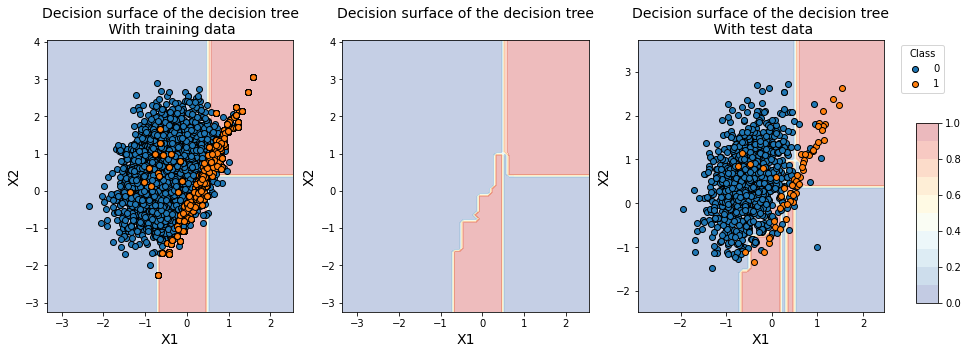

In [41]:
fig_decision_boundary

In [42]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.01+/-0.001,0.005+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.01+/-0.001,0.003+/-0.0,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03


#### SMOTE

SMOTE oversamples the minority class by generating synthetic examples in the neighborhood of observed ones. The idea is to form new minority examples by interpolating between samples of the same class. This has the effect of creating clusters around each minority observation. By creating synthetic observations, the classifier builds larger decision regions that contain nearby instances from the minority class. SMOTE has been shown to improve the performances of a base classifier in many applications 

In [43]:
from imblearn.over_sampling import SMOTE

In [44]:
%%capture

sampler_list = [('sampler', SMOTE(sampling_strategy=1, random_state=0))]
classifier = DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_SMOTE, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                           sampler_list, 
                                                                                           X, y, 
                                                                                           n_splits=5,
                                                                                           strategy_name="Decision tree - SMOTE")


fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [45]:
train_df['Y'].value_counts()


0    3784
1    3784
Name: Y, dtype: int64

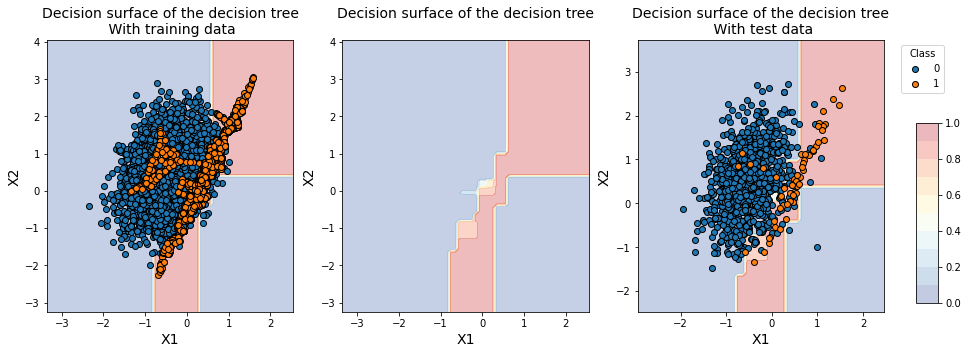

In [46]:
fig_decision_boundary


SMOTE provides higher performances than random oversampling for the three metrics. The Average Precision however remains lower than the baseline classifier.

In [47]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS,
           results_df_SMOTE])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.01+/-0.001,0.005+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.01+/-0.001,0.003+/-0.0,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03
Decision tree - SMOTE,0.017+/-0.002,0.005+/-0.001,0.913+/-0.032,0.499+/-0.056,0.91+/-0.019


### Undersampling

#### Random undersampling (RUS)

Undersampling refers to the process of reducing the number of samples in the majority class. The naive approach, called random undersampling (RUS), consists in randomly removing samples from the majority class until the desired imbalance ratio is achieved.

In [48]:
from imblearn.under_sampling import RandomUnderSampler

/tmp/ipykernel_55755/4137880621.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/tmp/ipykernel_55755/4137880621.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


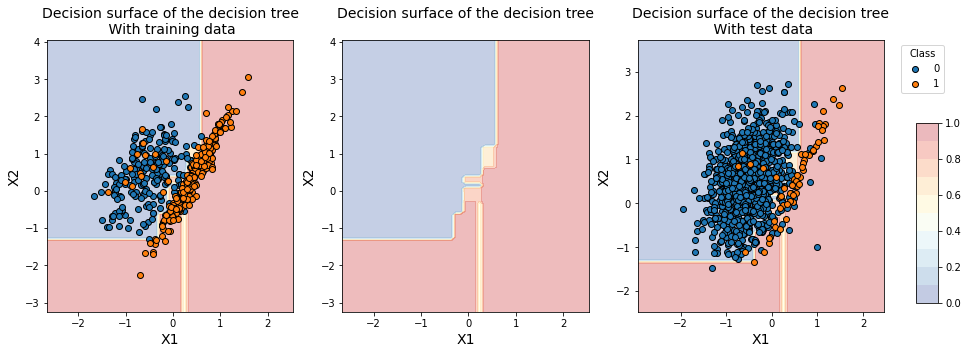

In [49]:
sampler_list = [('sampler', RandomUnderSampler(sampling_strategy=1, random_state=0))]

classifier = DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_RUS, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                         sampler_list, 
                                                                                         X, y, 
                                                                                         n_splits=5,
                                                                                         strategy_name="Decision tree - RUS")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [50]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS,
           results_df_SMOTE,
           results_df_RUS])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.01+/-0.001,0.005+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.01+/-0.001,0.003+/-0.0,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03
Decision tree - SMOTE,0.017+/-0.002,0.005+/-0.001,0.913+/-0.032,0.499+/-0.056,0.91+/-0.019
Decision tree - RUS,0.005+/-0.0,0.005+/-0.001,0.913+/-0.02,0.408+/-0.058,0.896+/-0.023


It is worth noting that the training time with RUS is faster. This results from the simple undersampling procedure and the smaller training set size. The method is therefore useful not only for reducing the imbalance ratio but also for speeding up the execution time of the modeling procedure.

#### Edited Nearest Neighbor

The Edited Nearest Neighbor rule is an undersampling technique that removes samples from the majority class in overlapping regions of the dataset. It is based on a nearest neighbor rule, that removes majority class samples as follows:

- For each majority class sample, the k-nearest neighbors are found. If the majority of these samples are from the minority class, the majority class sample is removed.

- For each minority class sample, the k-nearest neighbors are found. If the majority of these samples are from the majority class, the majority class sample(s) is (are) removed

In [51]:
from imblearn.under_sampling import EditedNearestNeighbours

In [52]:
%%capture

sampler_list = [('sampler', EditedNearestNeighbours(sampling_strategy='majority',n_neighbors=3))]

classifier = DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_ENN, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                         sampler_list, 
                                                                                         X, y, 
                                                                                         n_splits=5,
                                                                                         strategy_name="Decision tree - ENN")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

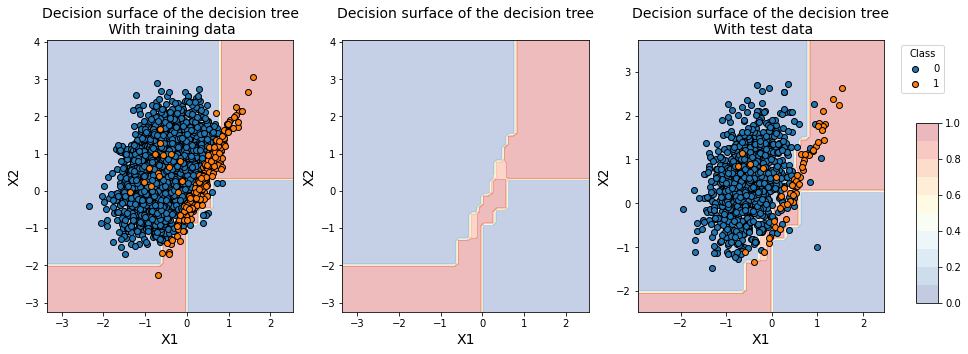

In [53]:
fig_decision_boundary

With a number of neighbors n_neighbors set to three, ENN only removes around 200 samples out of the 3784 samples of the majority class. The number of samples from the minority class is unchanged.

In [54]:
train_df['Y'].value_counts()

0    3572
1     216
Name: Y, dtype: int64

On this dataset, the performances of ENN are poor compared to the previsouly tested techniques. The balanced accuracy was slightly improved compared to the baseline classifier. The performance in terms of AP is however lower than the baseline, and the AUC ROC is the worst of all tested tecniques (and on par with ROS).

In [55]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS,
           results_df_SMOTE,
           results_df_RUS,
           results_df_ENN])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.01+/-0.001,0.005+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.01+/-0.001,0.003+/-0.0,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03
Decision tree - SMOTE,0.017+/-0.002,0.005+/-0.001,0.913+/-0.032,0.499+/-0.056,0.91+/-0.019
Decision tree - RUS,0.005+/-0.0,0.005+/-0.001,0.913+/-0.02,0.408+/-0.058,0.896+/-0.023
Decision tree - ENN,0.017+/-0.002,0.005+/-0.001,0.879+/-0.038,0.474+/-0.08,0.857+/-0.041


### Combining over and undersampling

Oversampling and undersampling are often complementary. 
- **Oversampling techniques** allow to generate synthetic samples from the minority class, and help a classifier in identifying more precisely the decision boundary between the two classes. 
- **Undersampling techniques** reduce the size of the training set, and allow to speed-up the classifier training time. Combining over and undersampling techniques has often been reported to successfully improve the classifier performances

In [56]:
from imblearn.pipeline import Pipeline

In [57]:
   
pipe = Pipeline(steps =  [('sampler1', SMOTE(sampling_strategy=0.5,random_state=0)),
                          ('sampler2', RandomUnderSampler(sampling_strategy=1.0,random_state=0)),
                          ('clf', DecisionTreeClassifier(max_depth=5, random_state=0))
                         ])

In [58]:
%%capture
sampler_list = [('sampler1', SMOTE(sampling_strategy=0.5,random_state=0)),
                ('sampler2', RandomUnderSampler(sampling_strategy=1.0,random_state=0))
               ]

classifier = DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_combined, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                              sampler_list, 
                                                                                              X, y, 
                                                                                              n_splits=5,
                                                                                              strategy_name='Decision tree - Combined SMOTE and RUS')

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [59]:
train_df['Y'].value_counts()


0    1892
1    1892
Name: Y, dtype: int64

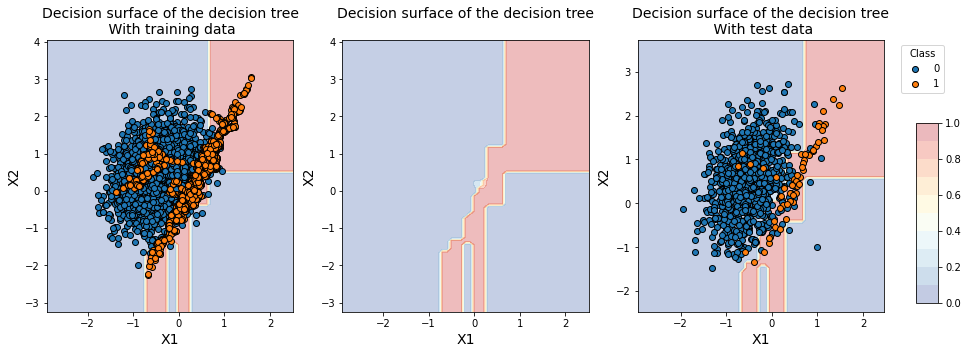

In [60]:
fig_decision_boundary

In [61]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS,
           results_df_SMOTE,
           results_df_RUS,
           results_df_ENN,
           results_df_combined])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.01+/-0.001,0.005+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.01+/-0.001,0.003+/-0.0,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03
Decision tree - SMOTE,0.017+/-0.002,0.005+/-0.001,0.913+/-0.032,0.499+/-0.056,0.91+/-0.019
Decision tree - RUS,0.005+/-0.0,0.005+/-0.001,0.913+/-0.02,0.408+/-0.058,0.896+/-0.023
Decision tree - ENN,0.017+/-0.002,0.005+/-0.001,0.879+/-0.038,0.474+/-0.08,0.857+/-0.041
Decision tree - Combined SMOTE and RUS,0.014+/-0.001,0.005+/-0.001,0.915+/-0.012,0.494+/-0.062,0.912+/-0.005


# Ensemble learning for imbalanced data

## Bagging

Bagging relies on the concept of bootstrap aggregating, which consists of training several baseline learners with different replicas of the original training set. The most usual practice is to randomly draw, with replacement, instances from the original dataset. The dataset size is maintained, meaning that approximately 63.2% of the instances are present in each sample (and some instances appear more than once)

In [62]:
from sklearn.ensemble import BaggingClassifier

In [63]:
%%capture
classifier = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=5,random_state=0),
                                                n_estimators=100,
                                                bootstrap=True,
                                                random_state=0)


(results_df_bagging, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                 X, y, 
                                                                                 n_splits=5,
                                                                                 strategy_name="Bagging")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [64]:
results_df_bagging

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.454+/-0.016,0.041+/-0.006,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041


The classification performances of this bagging classifier are better than those of a single decision tree  for AUC ROC and Average Precision but lower in terms of balanced accuracy.

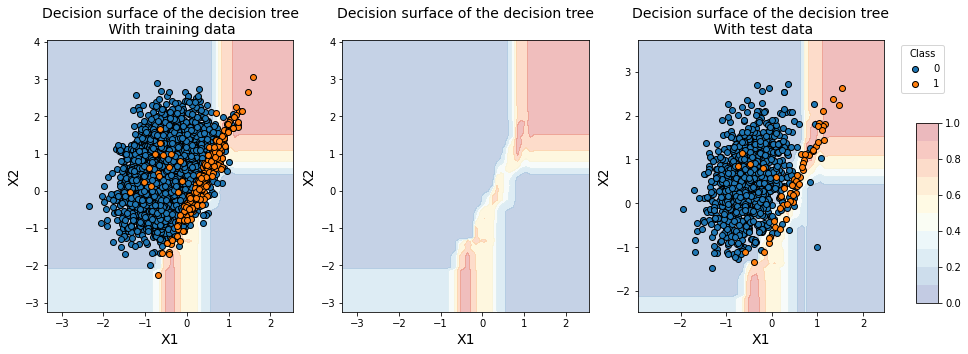

In [65]:
fig_decision_boundary

Compared to a single decision tree, the decision boundary is more refined. Most of the samples lying on the overlapping region are however classified into the majority class due to the imbalanced nature of the dataset.

## Balanced Bagging

In [66]:
from imblearn.ensemble import BalancedBaggingClassifier

In [67]:
%%capture
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,random_state=0),
                                                         n_estimators=100,
                                                         sampling_strategy=1,
                                                         bootstrap=True,
                                                         sampler=RandomUnderSampler(),
                                                         random_state=0)


(results_df_balanced_bagging, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                          X, y, 
                                                                                          n_splits=5,
                                                                                          strategy_name="Balanced bagging")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [68]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.454+/-0.016,0.041+/-0.006,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.362+/-0.013,0.042+/-0.001,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013


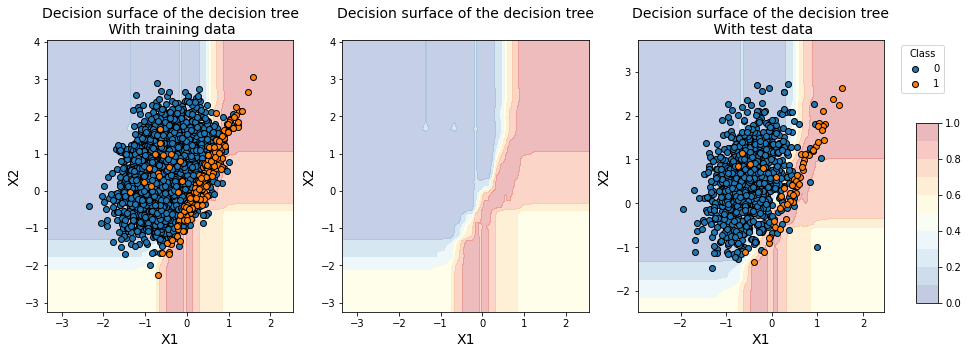

In [69]:
fig_decision_boundary

## Random forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
%%capture
classifier = RandomForestClassifier(n_estimators=100, 
                                                     max_depth=5,
                                                     random_state=0)

(results_df_rf, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                            X, y, 
                                                                            n_splits=5,
                                                                            strategy_name="Random forest")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [74]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging,
           results_df_rf])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.454+/-0.016,0.041+/-0.006,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.362+/-0.013,0.042+/-0.001,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013
Random forest,0.312+/-0.018,0.038+/-0.004,0.933+/-0.016,0.593+/-0.087,0.672+/-0.022


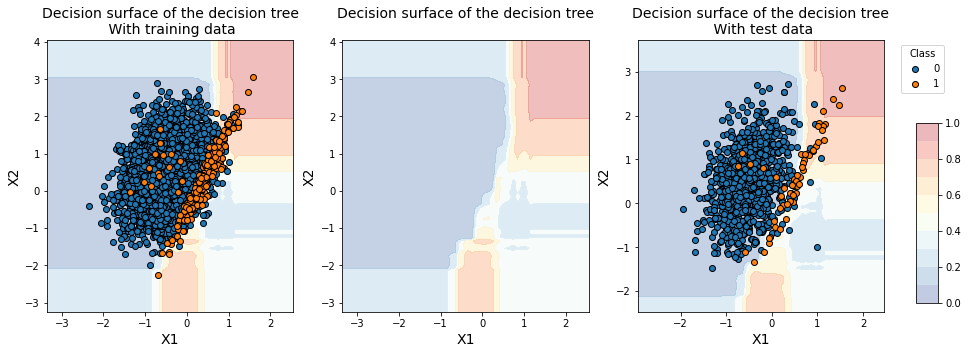

In [75]:
fig_decision_boundary

## Balanced random forest

In [76]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [77]:
%%capture
classifier = BalancedRandomForestClassifier(n_estimators=100, 
                                            sampling_strategy=1,
                                            max_depth=5,
                                            random_state=0)

(results_df_rf_balanced, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                     X, y, 
                                                                                     n_splits=5,
                                                                                     strategy_name="Balanced random forest")


fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [78]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging,
           results_df_rf,
           results_df_rf_balanced])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.454+/-0.016,0.041+/-0.006,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.362+/-0.013,0.042+/-0.001,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013
Random forest,0.312+/-0.018,0.038+/-0.004,0.933+/-0.016,0.593+/-0.087,0.672+/-0.022
Balanced random forest,0.353+/-0.024,0.039+/-0.004,0.946+/-0.01,0.58+/-0.083,0.916+/-0.014


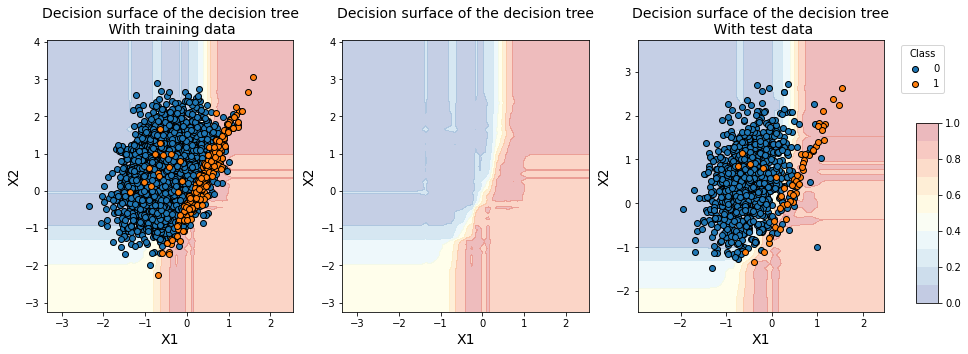

In [79]:
fig_decision_boundary

## XGBoost

In [82]:
from xgboost import XGBClassifier

In [83]:
%%capture
classifier = XGBClassifier(n_estimators=100,
                                   max_depth=6,
                                   learning_rate=0.3,
                                   random_state=0)

(results_df_xgboost, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                 X, y, 
                                                                                 n_splits=5,
                                                                                 strategy_name="XGBoost")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [84]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging,
           results_df_rf,
           results_df_rf_balanced,
           results_df_xgboost])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.454+/-0.016,0.041+/-0.006,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.362+/-0.013,0.042+/-0.001,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013
Random forest,0.312+/-0.018,0.038+/-0.004,0.933+/-0.016,0.593+/-0.087,0.672+/-0.022
Balanced random forest,0.353+/-0.024,0.039+/-0.004,0.946+/-0.01,0.58+/-0.083,0.916+/-0.014
XGBoost,0.65+/-0.066,0.012+/-0.002,0.95+/-0.008,0.59+/-0.066,0.772+/-0.04


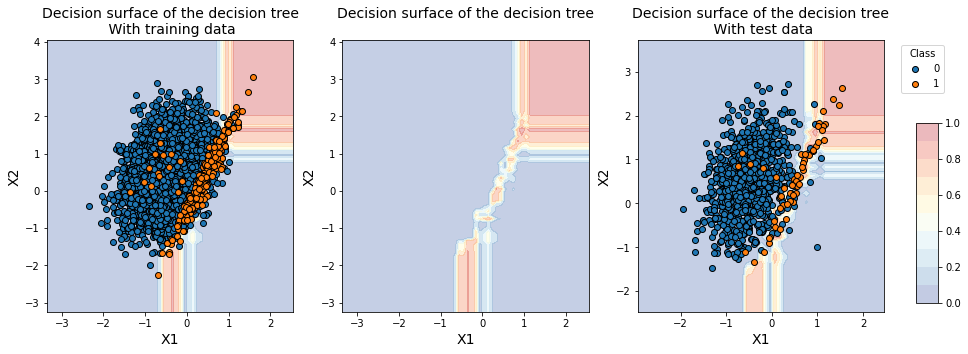

In [85]:
fig_decision_boundary


## Weighted XGBoost

In [86]:
IR=0.05/0.95 
IR

0.052631578947368425

In [87]:
%%capture
classifier = XGBClassifier(n_estimators=100,
                                   max_depth=6,
                                   learning_rate=0.3,
                                   scale_pos_weight=1/IR,
                                   random_state=0)

(results_df_weighted_xgboost, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                          X, y, 
                                                                                          n_splits=5,
                                                                                          strategy_name="Weighted XGBoost")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [88]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging,
           results_df_rf,
           results_df_rf_balanced,
           results_df_xgboost,
           results_df_weighted_xgboost])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.454+/-0.016,0.041+/-0.006,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.362+/-0.013,0.042+/-0.001,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013
Random forest,0.312+/-0.018,0.038+/-0.004,0.933+/-0.016,0.593+/-0.087,0.672+/-0.022
Balanced random forest,0.353+/-0.024,0.039+/-0.004,0.946+/-0.01,0.58+/-0.083,0.916+/-0.014
XGBoost,0.65+/-0.066,0.012+/-0.002,0.95+/-0.008,0.59+/-0.066,0.772+/-0.04
Weighted XGBoost,0.855+/-0.339,0.011+/-0.0,0.946+/-0.012,0.598+/-0.061,0.855+/-0.021


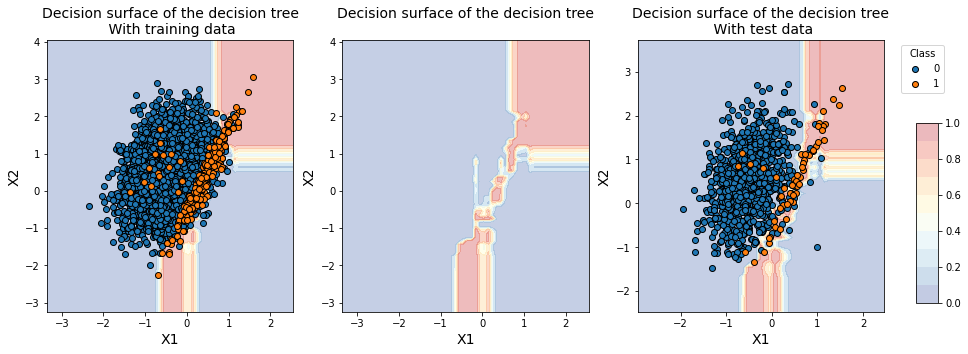

In [89]:
fig_decision_boundary